In [1]:
# Before we begin, we supress deprecation warnings resulting from nltk on Kaggle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Sentiment classification on tweets about airlines

This notebook describes an attempt to classify tweets by sentiment. It describes the initial data exploration, as well as implementation of a classifier.

## What is in the dataset?

It's always good to start by exploring the data that we have available. To do this we load the raw csv file using [Pandas][1] and check what the columns are.

  [1]: http://pandas.pydata.org/

In [2]:
import pandas as pd
tweets = pd.read_csv("../input/Tweets.csv")
list(tweets.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

We want to be able to determine the sentiment of a tweet without any other information but the tweet text itself, hence the 'text' column is our focus. Using the text we are going to try and predict 'airline_sentiment'.

First we take a look at what a typical record looks like.

In [3]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Now lets take a look at what sentiments have been found.

In [4]:
sentiment_counts = tweets.airline_sentiment.value_counts()
number_of_tweets = tweets.tweet_id.count()
print(sentiment_counts)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


It turns out that our dataset is unbalanced with significantly more negative than positive tweets. We will focus on the issue of identifying negative tweets, and hence treat neutral and positive as one class. It's good to keep in mind that, while a terrible classifier, if we always guessed a tweet was negative we'd be right 62.7% of the time (9178 of 14640). That clearly wouldn't be a very useful classifier, but worth to remember.

# What characterizes text of different sentiments?

While we still haven't decided what classification method to use, it's useful to get an idea of how the different texts look. This might be an "old school" approach in the age of deep learning, but lets indulge ourselves nevertheless. 

To explore the data we apply some crude preprocessing. We will tokenize and lemmatize using [Python NLTK][1], and transform to lower case. As words mostly matter in context we'll look at bi-grams instead of just individual tokens.

As a way to simplify later inspection of results we will store all processing of data together with it's original form. This means we will extend the Pandas dataframe into which we imported the raw data with new columns as we go along.

### Preprocessing
Note that we remove the first two tokens as they always contain "@ airline_name". We begin by defining our normalization function.


  [1]: http://www.nltk.org/

In [5]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    #lower_case = [l.lower() for l in tokens]
    #filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    #lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return tokens

In [6]:
normalizer("I recently wrote some texts.")

['wrote', 'some', 'texts']

In [7]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
tweets['normalized_tweet'] = tweets.text.apply(normalizer)
tweets[['text','normalized_tweet']].head()

,text,normalized_tweet
0,@VirginAmerica What @dhepburn said.,"[dhepburn, said]"
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[you, ve, added, commercials, to, the, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[didn, t, today, Must, mean, I, need, to, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[s, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, amp, they, have, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[it, s, a, really, big, bad, thing, about, it]"


In [8]:
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
tweets['grams'] = tweets.normalized_tweet.apply(ngrams)
tweets[['grams']].head()

,grams
0,[dhepburn said]
1,"[you ve, ve added, added commercials, commercials to, to the, the experience, experience tacky, you ve added, ve added commercials, added commercials to, commercials to the, to the experience, the experience tacky]"
2,"[didn t, t today, today Must, Must mean, mean I, I need, need to, to take, take another, another trip, didn t today, t today Must, today Must mean, Must mean I, mean I need, I need to, need to take, to take another, take another trip]"
3,"[s really, really aggressive, aggressive to, to blast, blast obnoxious, obnoxious entertainment, entertainment in, in your, your guests, guests faces, faces amp, amp they, they have, have little, little recourse, s really aggressive, really aggressive to, aggressive to blast, to blast obnoxious, blast obnoxious entertainment, obnoxious entertainment in, entertainment in your, in your guests, your guests faces, guests faces amp, faces amp they, amp they have, they have little, have little recourse]"
4,"[it s, s a, a really, really big, big bad, bad thing, thing about, about it, it s a, s a really, a really big, really big bad, big bad thing, bad thing about, thing about it]"


And now some counting.

In [9]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [10]:
tweets[(tweets.airline_sentiment == 'negative')][['grams']].apply(count_words)['grams'].most_common(20)

[('t co', 452),
 ('on hold', 445),
 ('http t', 435),
 ('http t co', 435),
 ('Cancelled Flightled', 424),
 ('on the', 420),
 ('customer service', 404),
 ('can t', 377),
 ('I m', 366),
 ('to get', 365),
 ('don t', 330),
 ('my flight', 320),
 ('to be', 272),
 ('for a', 255),
 ('hold for', 242),
 ('a flight', 239),
 ('I have', 225),
 ('an hour', 224),
 ('for the', 216),
 ('Late Flight', 215)]

We can already tell there's a pattern here. Sentences like "cancelled flight", "late flight", "booking problems",  "delayed flight" stand out clearly. Lets check the positive tweets.

In [11]:
tweets[(tweets.airline_sentiment == 'positive')][['grams']].apply(count_words)['grams'].most_common(20)

[('t co', 233),
 ('http t', 217),
 ('http t co', 217),
 ('for the', 169),
 ('Thank you', 130),
 ('you for', 98),
 ('customer service', 87),
 ('in the', 67),
 ('Thanks for', 66),
 ('so much', 63),
 ('thank you', 63),
 ('to the', 62),
 ('the best', 61),
 ('I m', 57),
 ('you guys', 55),
 ('a great', 46),
 ('for your', 46),
 ('on the', 46),
 ('of the', 42),
 ('to get', 42)]

Some more good looking patterns here. We can however see that with 3-grams clear patterns are rare. "great customer service" occurs 12 times in 2362 positive responses, which really doesn't say much in general. 

Satisfied that our data looks possible to work with begin to construct our first classifier.

# First Classifier
Lets start simple with a bag-of-words Support-Vector-Machine (SVM) classifier. Bag-of-words means that we represent each sentence by the unique words in it. To make this representation useful for our SVM classifier we transform each sentence into a vector. The vector is of the same length as our vocabulary, i.e. the list of all words observed in our training data, with each word representing an entry in the vector. If a particular word is present, that entry in the vector is 1, otherwise 0.

To create these vectors we use the CountVectorizer from [sklearn][1]. 


  [1]: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Preparing the data

In [12]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [13]:
vectorized_data = count_vectorizer.fit_transform(tweets.text)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [14]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = tweets.airline_sentiment.apply(sentiment2target)

To check performance of our classifier we want to split our data in to train and test.

In [15]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

## Fitting a classifier

We're now ready to fit a classifier to our data. We'll spend more time on hyper parameter tuning later, so for now we just pick some reasonable guesses.

In [16]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(data_train, targets_train)

## Evaluation of results

In [17]:
clf.score(data_test, targets_test)

0.78517759562841527

It's most likely possible to achieve a higher score with more tuning, or a more advanced approach. Lets check on how it does on a couple of sentences.

In [18]:
sentences = count_vectorizer.transform([
    "What a great airline, the trip was a pleasure!",
    "My issue was quickly resolved after calling customer support. Thanks!",
    "What the hell! My flight was cancelled again. This sucks!",
    "Service was awful. I'll never fly with you again.",
    "You fuckers lost my luggage. Never again!",
    "I have mixed feelings about airlines. I don't know what I think.",
    ""
])
clf.predict_proba(sentences)

array([[ 0.21029514,  0.05652951,  0.73317535],
       [ 0.14223747,  0.06864099,  0.78912154],
       [ 0.94417639,  0.03773949,  0.01808412],
       [ 0.89174367,  0.06987931,  0.03837702],
       [ 0.97440976,  0.01593846,  0.00965178],
       [ 0.46542834,  0.50278218,  0.03178948],
       [ 0.26230673,  0.52534278,  0.21235049]])

So while results aren't very impressive overall, we can see that it's doing a good job on these obvious sentences. 

## What is hard for the classifier?

It's interesting to know which sentences are hard. To find out, lets apply the classifier to all our test sentences and sort by the marginal probability.

Here are some of the hardest sentences.

In [19]:
predictions_on_test_data = clf.predict_proba(data_test)
index = np.transpose(np.array([range(0,len(predictions_on_test_data))]))
indexed_predictions = np.concatenate((predictions_on_test_data, index), axis=1).tolist()

In [20]:
def margin(p):
    top2 = p.argsort()[::-1]
    return abs(p[top2[0]]-p[top2[1]])
margin = sorted(list(map(lambda p : [margin(np.array(p[0:3])),p[3]], indexed_predictions)), key=lambda p : p[0])
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].text, margin[0:10]))

['@JetBlue - Definitely no note from whoever stole from me.',
 '@AmericanAir the pilot her and another flight attendant left walking away laughing.  Just wow',
 '@JetBlue two rows',
 "@USAirways that's it?!?!?",
 '@united thx. Come hell or high water...',
 "@SouthwestAir please do. Hate having to fly a different airline. You're my fav.",
 '@united How can I verify if wheelchair assistance has been requested for my next flight?',
 "@VirginAmerica that doesn't look to fat to me! It looks yummy!",
 '@JetBlue A320 pulling into the gate as the sunrises here at @BostonLogan this morning #jetbluesofly #jetblue #airbus http://t.co/JGdu5us8Dz',
 '@SouthwestAir @karajusto SWA is willing to follow up. FINALLY.']

and their probability distributions?

In [21]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[0:10]))

[array([ 0.4710575,  0.057885 ,  0.4710575]),
 array([ 0.40647557,  0.18695564,  0.40656879]),
 array([ 0.36004085,  0.36028693,  0.27967222]),
 array([ 0.42181709,  0.42214182,  0.1560411 ]),
 array([ 0.37913878,  0.24139125,  0.37946997]),
 array([ 0.4874887 ,  0.02456077,  0.48795053]),
 array([ 0.48948237,  0.48888557,  0.02163206]),
 array([ 0.33786309,  0.3387592 ,  0.32337772]),
 array([ 0.40338832,  0.19230461,  0.40430707]),
 array([ 0.37969834,  0.241662  ,  0.37863966])]

How about the easiest sentences?

In [22]:
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].text, margin[-10:]))

['@united here we go again. 2 of 3 segments SFO--New York RT were delayed OVER 2 hrs each! Why do you suck so BAD!?!Maybe another line of bus?',
 '@USAirways Been stuck for 40+ minutes due to lavatory issues. No beverages. No snacks. No customer service. Flt 645 to PHO... #fail #refund',
 '@united is the worst airline. Lost my luggage delayed my flights and has been very unaccomidating',
 '@AmericanAir Worst airline ever. We have been stranded for 24 hours because of your 7 hour delay with flight 104 last night.',
 "@USAirways seriously???  did you not see that I've spent 2 days - for multiple hours on hold just to have to hang up after the hours?",
 '@AmericanAir AA 1657 was also over an hour Late Flight to depart Ohare and now we have no luggage. Not happy standing in a long line at baggage svc',
 '@USAirways waited for 3 hours NO LUGGAGE line too long left airport when flight Cancelled Flighted WHERE does luggage GO? On hold for 1 hour so far',
 '@united you are the worst airline in

and their probability distributions?

In [23]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[-10:]))

[array([ 0.9973981 ,  0.00150321,  0.00109869]),
 array([  9.97959200e-01,   1.15815059e-03,   8.82649478e-04]),
 array([  9.98100500e-01,   1.27212933e-03,   6.27370278e-04]),
 array([  9.98818886e-01,   9.65640484e-04,   2.15473969e-04]),
 array([  9.98916502e-01,   1.00818159e-03,   7.53162850e-05]),
 array([  9.98754729e-01,   6.16379892e-04,   6.28891190e-04]),
 array([  9.99111825e-01,   7.89843241e-04,   9.83322504e-05]),
 array([  9.99157632e-01,   1.70161312e-04,   6.72206572e-04]),
 array([  9.99082423e-01,   5.06035649e-04,   4.11541474e-04]),
 array([  9.99487951e-01,   2.97798508e-04,   2.14250929e-04])]

Looks like all of the easiest sentences are negative. What is the distribution of certainty across all sentences?

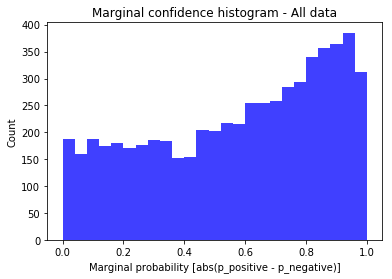

In [24]:
import matplotlib.pyplot as plt
marginal_probs = list(map(lambda p : p[0], margin))
n, bins, patches = plt.hist(marginal_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - All data')
plt.ylabel('Count')
plt.xlabel('Marginal probability [abs(p_positive - p_negative)]')
plt.show()

Lets break it down by positive and negative sentiment to see if one is harder than the other.

### Positive data

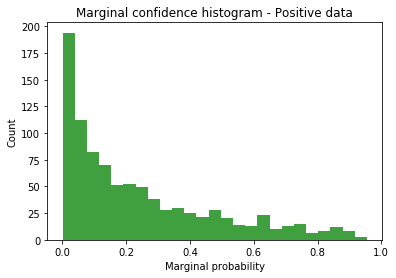

In [25]:
positive_test_data = list(filter(lambda row : row[0]==2, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : abs(p[0]-p[1]), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='green', alpha=0.75)
plt.title('Marginal confidence histogram - Positive data')
plt.ylabel('Count')
plt.xlabel('Marginal probability')
plt.show()

### Neutral data

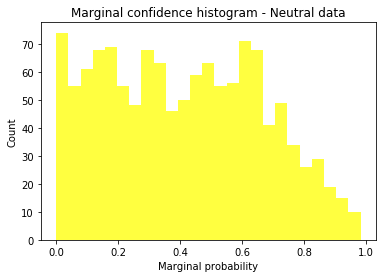

In [26]:
positive_test_data = list(filter(lambda row : row[0]==1, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : abs(p[0]-p[1]), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='yellow', alpha=0.75)
plt.title('Marginal confidence histogram - Neutral data')
plt.ylabel('Count')
plt.xlabel('Marginal probability')
plt.show()

### Negative data

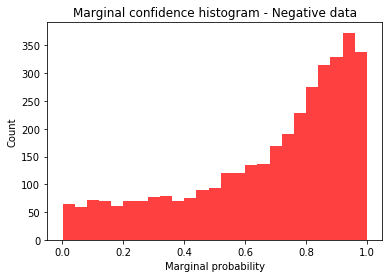

In [27]:
negative_test_data = list(filter(lambda row : row[0]==0, hstack((targets_test[:,None], data_test)).toarray()))
negative_probs = clf.predict_proba(list(map(lambda r : r[1:], negative_test_data)))
marginal_negative_probs = list(map(lambda p : abs(p[0]-p[1]), negative_probs))
n, bins, patches = plt.hist(marginal_negative_probs, 25, facecolor='red', alpha=0.75)
plt.title('Marginal confidence histogram - Negative data')
plt.ylabel('Count')
plt.xlabel('Marginal probability')
plt.show()

Clearly the positive data is much harder for the classifier. This makes sense since there's a lot less of it. An important challenge in building a classifier will then be how to handle positive data.

# In Progress
# Second classifier - Convolutional Neural Network

We're going to build a classifier based on convolutional neural networks.  A good resource for learning about Deep Learning (and machine learning in general) is [Christopher Olah's blog][1]. The convolution neural network approach in particular is explained nicely in [this post][2] by WildML. Finally I recommend [this paper][3] by Yoon Kim, then at NYU. I'll leave these resources to explain the theory behind our approach, and instead focus on getting a working implementation.


  [1]: http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/
  [2]: http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
  [3]: https://arxiv.org/pdf/1408.5882.pdf

# Word Embeddings
Word embeddings, or vector representations of words, are critical to building a CNN classifier. The vector representations of words are what will build up our input matrix. These vector space models represent words in a vector space such that similar words are mapped to nearby points. This representation rests on the [Distributional Hypothesis][1], i.e. assumption that words that appear in similar contexts share semantic meaning. We will use gensim to train word embeddings from our corpus.


  [1]: https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_Hypothesis

In [28]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 7           # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [29]:
from gensim.models import word2vec
model = word2vec.Word2Vec(tweets.normalized_tweet, workers=num_workers, \
                          size=num_features, min_count = min_word_count, \
                          window = context, sample = downsampling)
model.init_sims(replace=True)

Using TensorFlow backend.


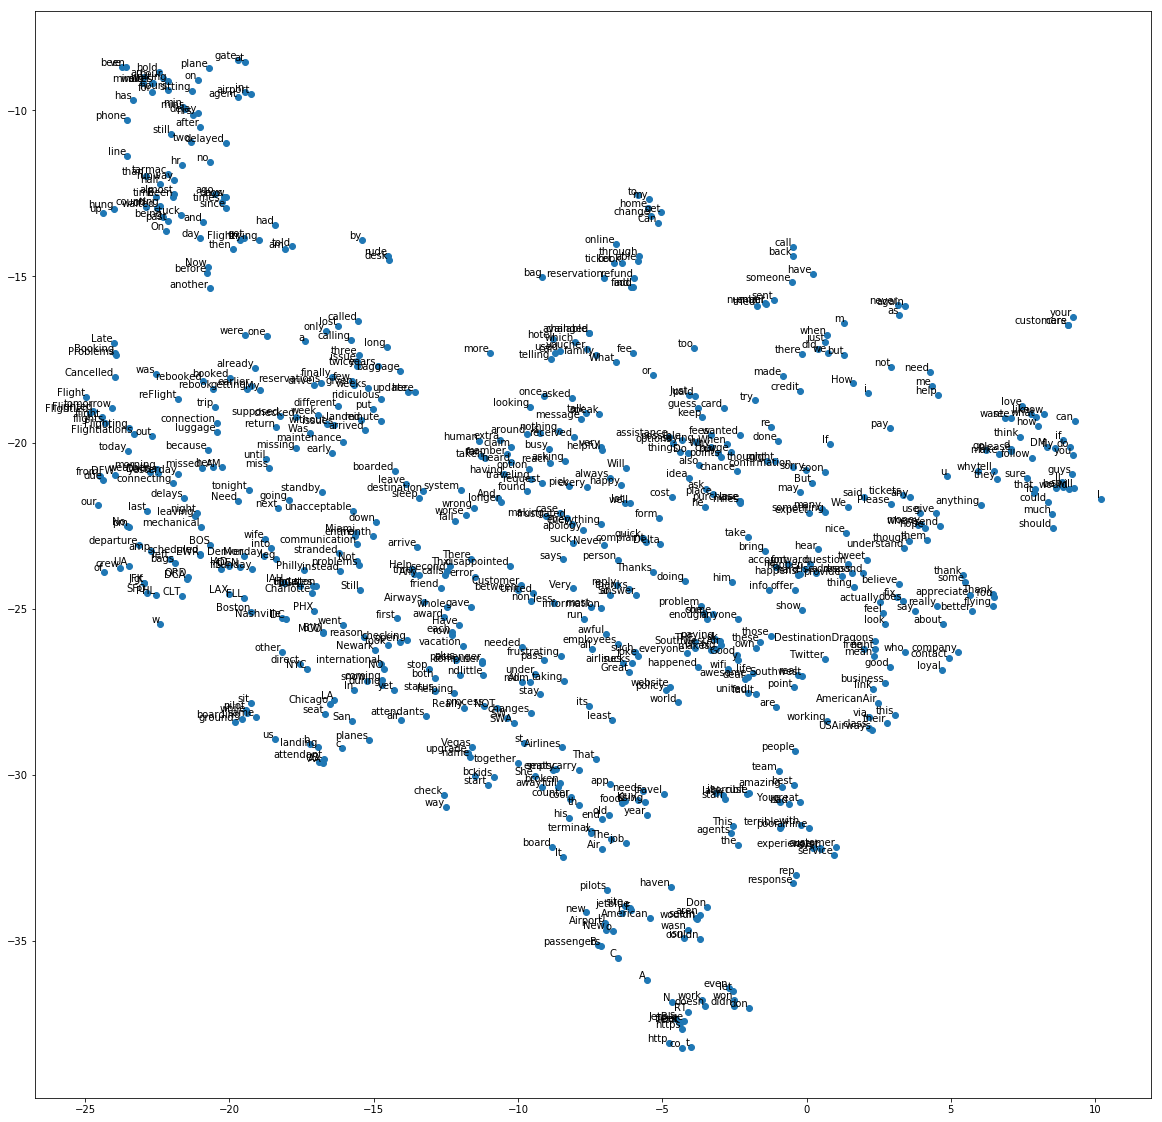

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X = model[model.wv.vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
labels = list(model.wv.vocab.keys())
for label, x, y in zip(labels, X_tsne[:, 0], X_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, -1),
        textcoords='offset points', ha='right', va='bottom')

plt.show()